Using device: cuda
Starting data loading...
Total data points loaded: 3367075
Created 1683 sequences.
Train: 1178, Val: 252, Test: 253

--- Training model for confidence scoring for 5 epochs ---
Confidence Model Training - Epoch 1/5, Loss: 0.5798
Confidence Model Training - Epoch 2/5, Loss: 0.2413
Confidence Model Training - Epoch 3/5, Loss: 0.2025
Confidence Model Training - Epoch 4/5, Loss: 0.1971
Confidence Model Training - Epoch 5/5, Loss: 0.1883
--- Confidence model training finished ---
CurriculumSampler initialized with model-based confidence scores for 1178 samples.
DataLoaders created. Training uses CurriculumBatchSampler with model-based confidence.

--- Starting Combined Model Training (MultiModal Extractor + Hybrid Classifier) ---
Training for 100 epochs with batch size 32.
LR Warmup for 5 epochs. Gradient Clipping at 1.0.
Epoch 1/100 - 0.83s - Train Loss: 1.0290, Train Acc: 0.3998 - Val Loss: 0.8415, Val Acc: 0.8056 - LR: 6.2e-05
  New best model saved with Val Acc: 0.8056

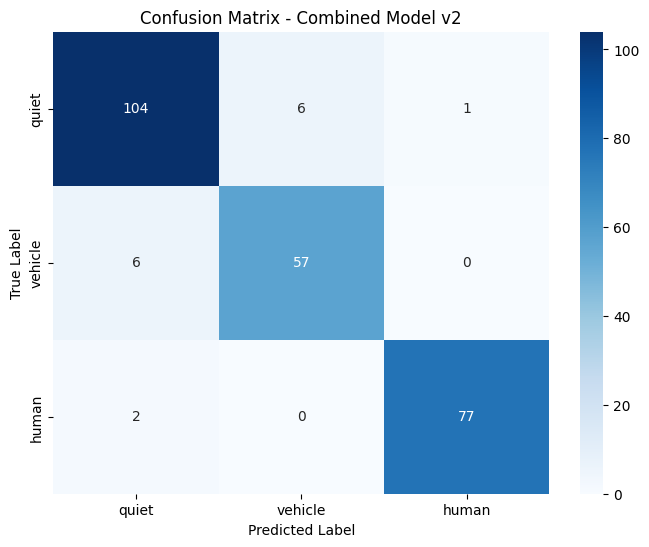

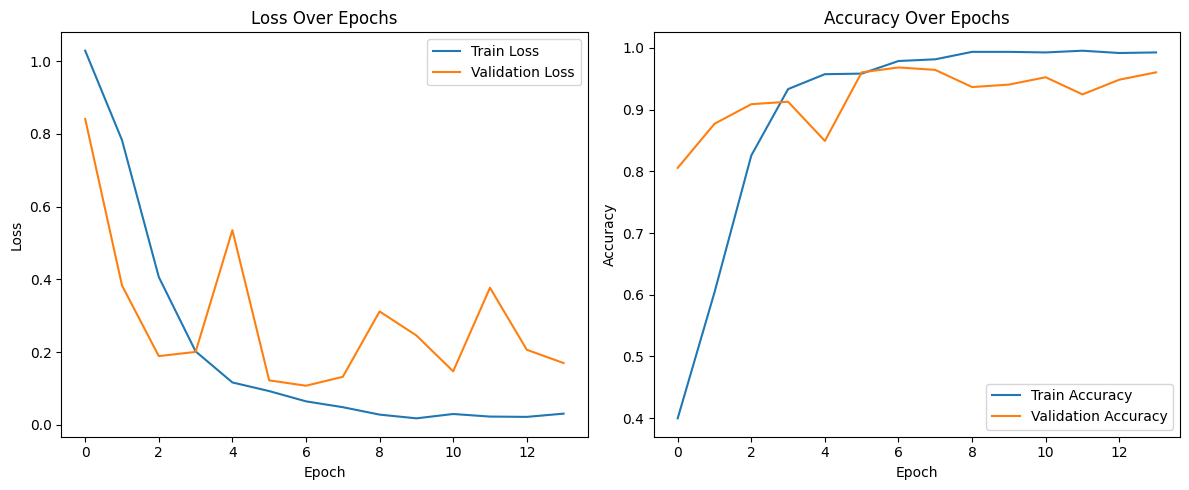


--- PyTorch Pipeline with Curriculum, Warmup, Clipping Completed ---


In [18]:
# Part 0: Setup and Global Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Sampler
import torch.nn.functional as F
import glob
import os
import time
import random
import librosa

# For reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Define global constants ---
DATA_PATH = "data/"
SEQUENCE_LENGTH = 2000
ENCODING_DIM = 64
CLASSIFIER_TRAIN_EPOCHS = 100 # Total epochs for main training
CLASSIFIER_BATCH_SIZE = 32
CLASSIFIER_PATIENCE = 7 # Increased patience for ReduceLROnPlateau
GRADIENT_CLIP_VALUE = 1.0 # NEW: For gradient clipping

# LR Warmup Parameters (NEW)
WARMUP_EPOCHS = 5
INITIAL_LR_WARMUP_FACTOR = 0.01 # Start at 1% of target LR

# Curriculum Learning Parameters (NEW)
CONFIDENCE_TRAIN_EPOCHS = 5 # Epochs to train a model for confidence scoring

# Focused Focal Loss parameters
FOCUSED_LOSS_ALPHA = 0.75
FOCUSED_LOSS_GAMMA = 2.0
QUIET_HUMAN_PENALTY_WEIGHT = 2.0

# Augmentation probability
AUG_PROBABILITY = 0.5

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- New Component Definitions (MultiModalFeatureExtractor, HybridAttentionClassifier, FocusedFocalLoss, TSDataAugmenter - REMAINS THE SAME) ---
# ... (Paste the definitions of these classes from the previous version here) ...
# 1. Enhanced Multi-Modal Feature Extraction
class MultiModalFeatureExtractor(nn.Module):
    def __init__(self, input_dim=SEQUENCE_LENGTH, encoding_dim=ENCODING_DIM):
        super().__init__()
        self.temporal_encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, dilation=1, padding='same'),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, dilation=2, padding='same'),
            nn.GroupNorm(16, 64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.freq_encoder = nn.Sequential(
            nn.Linear(513, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fusion = nn.Sequential(
            nn.Linear(64 + 64, encoding_dim),
            nn.LayerNorm(encoding_dim)
        )

    def forward(self, x):
        temp_feat = self.temporal_encoder(x.unsqueeze(1)).squeeze(-1)
        x_np = x.cpu().detach().numpy()
        freq_feat_list = []
        for i in range(x_np.shape[0]):
            sample_np = x_np[i]
            freq_feat_list.append(self._compute_freq_features(sample_np))
        freq_feat_raw_batch = torch.stack(freq_feat_list).to(x.device)
        freq_feat = self.freq_encoder(freq_feat_raw_batch)
        combined_features = torch.cat([temp_feat, freq_feat], dim=1)
        fused_features = self.fusion(combined_features)
        return fused_features

    def _compute_freq_features(self, sample_np):
        S = np.abs(librosa.stft(sample_np, n_fft=1024, hop_length=512))
        fixed_size_S_features = np.mean(S, axis=1)
        return torch.tensor(fixed_size_S_features, dtype=torch.float32)

# 2. Enhanced Hybrid Attention Classifier
class HybridAttentionClassifier(nn.Module):
    def __init__(self, encoding_dim=ENCODING_DIM, num_classes=3, num_heads=4):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=encoding_dim, num_heads=num_heads, batch_first=True)
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=encoding_dim,
            nhead=num_heads,
            dim_feedforward=encoding_dim * 4,
            dropout=0.6,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=2)
        self.mlp = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        attn_out, _ = self.self_attn(x, x, x)
        x = x + attn_out
        trans_out = self.transformer_encoder(x)
        mlp_input = trans_out.squeeze(1)
        return self.mlp(mlp_input)

# 3. Enhanced Loss Function with Class Balancing
class FocusedFocalLoss(nn.Module):
    def __init__(self, alpha=FOCUSED_LOSS_ALPHA, gamma=FOCUSED_LOSS_GAMMA,
                 class_weights=None, quiet_human_penalty=QUIET_HUMAN_PENALTY_WEIGHT,
                 label_encoding={'quiet': 0, 'vehicle': 1, 'human': 2}):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
        self.quiet_human_penalty = quiet_human_penalty
        self.quiet_idx = label_encoding['quiet']
        self.human_idx = label_encoding['human']

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.class_weights, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss_elementwise = self.alpha * (1 - pt) ** self.gamma * ce_loss
        focal_loss = focal_loss_elementwise.mean()
        pred_probs = F.softmax(inputs, dim=1)
        quiet_mask = (targets == self.quiet_idx)
        human_mask = (targets == self.human_idx)
        penalty_q_as_h = (quiet_mask * pred_probs[:, self.human_idx]).sum()
        penalty_h_as_q = (human_mask * pred_probs[:, self.quiet_idx]).sum()
        num_relevant_samples = quiet_mask.sum() + human_mask.sum()
        if num_relevant_samples.item() > 0:
            confusion_penalty_mean = (penalty_q_as_h + penalty_h_as_q) / num_relevant_samples.float()
        else:
            confusion_penalty_mean = torch.tensor(0.0, device=inputs.device)
        total_loss = focal_loss + self.quiet_human_penalty * confusion_penalty_mean
        return total_loss

# 4. Enhanced Data Augmentation Pipeline
class TSDataAugmenter:
    def __init__(self, sample_rate=SEQUENCE_LENGTH):
        self.sample_rate = sample_rate

    def __call__(self, x, label):
        if label == 0:
            if random.random() < 0.7: x = self._add_sensor_noise(x)
            if random.random() < 0.5: x = self._random_dropout(x)
        elif label == 2:
            if random.random() < 0.7: x = self._time_warp(x)
            if random.random() < 0.5: x = self._amplitude_scale(x)
        return x

    def _add_sensor_noise(self, x, noise_level=0.03):
        return x + torch.randn_like(x) * noise_level

    def _time_warp(self, x, warp_factor=0.1):
        orig_length = x.shape[0]
        stretch_factor = 1.0 + (torch.rand(1).item() - 0.5) * 2 * warp_factor
        new_length = int(orig_length * (1 + stretch_factor))
        new_length = max(1, new_length)
        x_view = x.view(1, 1, orig_length)
        x_warped_intermediate = F.interpolate(x_view, size=new_length, mode='linear', align_corners=False).squeeze()
        if new_length == orig_length:
            return x_warped_intermediate
        else:
            if x_warped_intermediate.ndim == 0:
                x_warped_intermediate = x_warped_intermediate.unsqueeze(0)
            x_warped_intermediate_view = x_warped_intermediate.view(1, 1, -1)
            final_warped_x = F.interpolate(x_warped_intermediate_view, size=orig_length, mode='linear', align_corners=False).squeeze()
            return final_warped_x

    def _amplitude_scale(self, x, min_scale=0.8, max_scale=1.2):
        scale_factor = torch.empty(1).uniform_(min_scale, max_scale).item()
        return x * scale_factor

    def _random_dropout(self, x, max_drop_ratio=0.15):
        drop_mask = torch.rand_like(x) < max_drop_ratio
        x_dropped = x.clone()
        x_dropped[drop_mask] = 0.0
        return x_dropped

# --- Combined Model ---
class CombinedModel(nn.Module):
    def __init__(self, sequence_length=SEQUENCE_LENGTH, encoding_dim=ENCODING_DIM, num_classes=3):
        super().__init__()
        self.feature_extractor = MultiModalFeatureExtractor(input_dim=sequence_length, encoding_dim=encoding_dim)
        self.classifier = HybridAttentionClassifier(encoding_dim=encoding_dim, num_classes=num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

# --- NEW: Function to Train a Model for Confidence Scoring ---
def train_for_confidence_scores(confidence_model, train_loader_full, num_epochs, device, lr=1e-3):
    print(f"\n--- Training model for confidence scoring for {num_epochs} epochs ---")
    confidence_model.to(device)
    optimizer_conf = optim.AdamW(confidence_model.parameters(), lr=lr)
    criterion_conf = nn.CrossEntropyLoss() # Simple CE loss for this pre-training

    for epoch in range(num_epochs):
        confidence_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader_full:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer_conf.zero_grad()
            outputs = confidence_model(batch_X)
            loss = criterion_conf(outputs, batch_y)
            loss.backward()
            optimizer_conf.step()
            epoch_loss += loss.item() * batch_X.size(0)
        avg_epoch_loss = epoch_loss / len(train_loader_full.dataset)
        print(f"Confidence Model Training - Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")
    print("--- Confidence model training finished ---")
    return confidence_model


# --- MODIFIED: Curriculum Learning Sampler ---
class CurriculumBatchSampler(Sampler[list[int]]):
    def __init__(self, dataset_len, batch_size, total_main_epochs,
                 model_for_confidence, full_train_dataloader_for_confidence, # NEW parameters
                 confidence_train_epochs, # NEW parameter
                 device_for_confidence, # NEW parameter
                 phases=3, random_seed=SEED):
        self.dataset_len = dataset_len
        self.batch_size = batch_size
        self.total_main_epochs = total_main_epochs # Renamed from total_epochs to avoid confusion
        self.phases = phases
        self.current_phase = 0
        self.rng = np.random.default_rng(random_seed)

        # --- NEW: Compute confidence scores using a pre-trained model ---
        self.confidence_scores = self._compute_confidence_scores(
            model_for_confidence,
            full_train_dataloader_for_confidence,
            confidence_train_epochs,
            device_for_confidence
        )
        print(f"CurriculumSampler initialized with model-based confidence scores for {self.dataset_len} samples.")

    def _compute_confidence_scores(self, model_to_train, dataloader, num_train_epochs, device_conf):
        # Train the model (or use pre-trained if num_train_epochs is 0 and model is already trained)
        if num_train_epochs > 0:
            trained_model = train_for_confidence_scores(model_to_train, dataloader, num_train_epochs, device_conf)
        else:
            trained_model = model_to_train.to(device_conf) # Assume it's already trained and on device

        trained_model.eval()
        all_confidences = np.zeros(self.dataset_len)
        processed_samples = 0
        with torch.no_grad():
            # Iterate through the full training dataset (without shuffling for consistent indexing)
            for i, (batch_X, batch_y) in enumerate(dataloader): # dataloader should not be shuffled
                batch_X, batch_y = batch_X.to(device_conf), batch_y.to(device_conf)
                outputs = trained_model(batch_X)
                probs = F.softmax(outputs, dim=1)
                # Confidence = probability of the true class
                true_class_probs = probs[torch.arange(batch_X.size(0)), batch_y]

                # Correctly assign to all_confidences based on original indices if dataloader was not shuffled
                # For simplicity here, assuming dataloader iterates sequentially over the dataset
                start_idx = i * dataloader.batch_size
                end_idx = start_idx + batch_X.size(0)
                all_confidences[start_idx:end_idx] = true_class_probs.cpu().numpy()
                processed_samples += batch_X.size(0)

        if processed_samples != self.dataset_len:
            print(f"Warning: Processed {processed_samples} samples for confidence, but dataset size is {self.dataset_len}. Check dataloader for confidence scoring.")
        return all_confidences


    def _get_indices_for_phase(self):
        # Define thresholds based on confidence scores (higher score = easier)
        # These thresholds might need tuning
        if self.current_phase == 0:  # Easiest samples
            indices = np.where(self.confidence_scores >= 0.85)[0] # Stricter for "very easy"
        elif self.current_phase == 1:  # Medium difficulty samples
            indices = np.where((self.confidence_scores >= 0.50) & (self.confidence_scores < 0.85))[0]
        else:  # All samples, including hardest
            indices = np.arange(self.dataset_len)

        if len(indices) == 0:
            print(f"Warning: Phase {self.current_phase} selected 0 samples with current confidence thresholds. Falling back to all samples.")
            indices = np.arange(self.dataset_len)
        return indices

    def update_phase(self, epoch):
        if self.total_main_epochs == 0 or self.phases == 0:
            new_phase = 0
        else:
            phase_duration = self.total_main_epochs // self.phases
            if phase_duration == 0:
                new_phase = min(epoch, self.phases - 1)
            else:
                new_phase = min(self.phases - 1, epoch // phase_duration)

        if new_phase != self.current_phase:
            self.current_phase = new_phase
            print(f"Curriculum Sampler: Updated to Phase {self.current_phase} at epoch {epoch+1}")

    def __iter__(self):
        indices = self._get_indices_for_phase()
        self.rng.shuffle(indices)
        for i in range(0, len(indices), self.batch_size):
            batch = indices[i : i + self.batch_size]
            if len(batch) > 0:
                 yield list(batch)

    def __len__(self):
        indices = self._get_indices_for_phase()
        return (len(indices) + self.batch_size - 1) // self.batch_size

# --- Part 1: Data Loading and Preparation (REMAINS THE SAME) ---
# ... (Paste load_and_prepare_data, create_sequences, splits, normalization here) ...
def load_and_prepare_data(data_path_folder):
    file_mapping = {
        'car_nothing(AVI).csv': 'quiet',
        'carnew(AVI).csv': 'vehicle',
        'human_nothing(AVI).csv': 'quiet',
        'human(AVI).csv': 'human'
    }
    label_encoding = {'quiet': 0, 'vehicle': 1, 'human': 2}
    all_data, all_labels = [], []
    print("Starting data loading...")
    if not os.path.exists(data_path_folder):
        print(f"Data folder {data_path_folder} not found.")
        return np.array([]), np.array([])
    for filename, activity_type in file_mapping.items():
        filepath = os.path.join(data_path_folder, filename)
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}. Skipping.")
            continue
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty and df.shape[1] > 0:
                data = df.iloc[:, 0].values
                label_code = label_encoding[activity_type]
                all_data.extend(data)
                all_labels.extend([label_code] * len(data))
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    all_data_np = np.array(all_data)
    all_labels_np = np.array(all_labels)
    print(f"Total data points loaded: {len(all_data_np)}")
    return all_data_np, all_labels_np

X_raw, y_raw = load_and_prepare_data(DATA_PATH)
if len(X_raw) == 0: exit()

def create_sequences(data, labels, sequence_length):
    sequences, sequence_labels = [], []
    unique_labels_vals = np.unique(labels)
    for label_val in unique_labels_vals:
        label_indices = np.where(labels == label_val)[0]
        label_data = data[label_indices]
        if len(label_data) < sequence_length:
            continue
        num_sequences_for_label = len(label_data) // sequence_length
        for i in range(num_sequences_for_label):
            start_idx = i * sequence_length
            end_idx = start_idx + sequence_length
            sequences.append(label_data[start_idx:end_idx])
            sequence_labels.append(label_val)
    if not sequences: return np.array([]), np.array([])
    return np.array(sequences), np.array(sequence_labels)

X_sequences, y_sequences = create_sequences(X_raw, y_raw, SEQUENCE_LENGTH)
if len(X_sequences) == 0: exit()
print(f"Created {len(X_sequences)} sequences.")

X_train_seq, X_temp_seq, y_train_labels, y_temp_labels = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=SEED, stratify=y_sequences
)
X_val_seq, X_test_seq, y_val_labels, y_test_labels = train_test_split(
    X_temp_seq, y_temp_labels, test_size=0.5, random_state=SEED, stratify=y_temp_labels
)
print(f"Train: {len(X_train_seq)}, Val: {len(X_val_seq)}, Test: {len(X_test_seq)}")

scaler = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, 1); scaler.fit(X_train_flat)
X_train_normalized = scaler.transform(X_train_seq.reshape(-1, 1)).reshape(X_train_seq.shape)
X_val_normalized = scaler.transform(X_val_seq.reshape(-1, 1)).reshape(X_val_seq.shape)
X_test_normalized = scaler.transform(X_test_seq.reshape(-1, 1)).reshape(X_test_seq.shape)

# --- Modified AugmentedDataset (REMAINS THE SAME from previous version) ---
# ... (Paste AugmentedDataset class definition here) ...
class AugmentedDataset(Dataset):
    def __init__(self, X_data_normalized, y_labels, augmenter, augment_prob=AUG_PROBABILITY, is_train=True):
        self.X_data = X_data_normalized
        self.y_labels = y_labels
        self.augmenter = augmenter
        self.augment_prob = augment_prob
        self.is_train = is_train

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x_sample_orig = self.X_data[idx]
        y_label = self.y_labels[idx]
        x_sample_tensor = torch.tensor(x_sample_orig, dtype=torch.float32)
        if self.is_train and random.random() < self.augment_prob:
            x_sample_tensor = self.augmenter(x_sample_tensor, y_label)
        y_label_tensor = torch.tensor(y_label, dtype=torch.long)
        return x_sample_tensor, y_label_tensor

ts_augmenter = TSDataAugmenter(sample_rate=SEQUENCE_LENGTH)

# Create Datasets
train_dataset_clf = AugmentedDataset(X_train_normalized, y_train_labels, ts_augmenter, is_train=True)
val_dataset_clf = AugmentedDataset(X_val_normalized, y_val_labels, ts_augmenter, is_train=False)
test_dataset_clf = AugmentedDataset(X_test_normalized, y_test_labels, ts_augmenter, is_train=False)

# --- MODIFIED: DataLoaders Setup (for Curriculum Learning) ---
# DataLoader for the full training set (used for confidence scoring)
# IMPORTANT: shuffle=False for this loader to ensure indices match confidence scores
train_loader_full_for_confidence = DataLoader(train_dataset_clf,
                                              batch_size=CLASSIFIER_BATCH_SIZE, # Can be different from main training
                                              shuffle=False, # MUST BE FALSE
                                              num_workers=0,
                                              pin_memory=True if device.type == 'cuda' else False)

# Main model instance for confidence scoring (can be the same architecture or a simpler one)
# For simplicity, using the same architecture. A new instance is created.
num_unique_classes = len(np.unique(y_sequences))
model_for_confidence_scoring = CombinedModel(sequence_length=SEQUENCE_LENGTH,
                                             encoding_dim=ENCODING_DIM,
                                             num_classes=num_unique_classes) # No .to(device) yet

# Instantiate Curriculum Sampler
train_sampler = CurriculumBatchSampler(dataset_len=len(train_dataset_clf),
                                       batch_size=CLASSIFIER_BATCH_SIZE,
                                       total_main_epochs=CLASSIFIER_TRAIN_EPOCHS,
                                       model_for_confidence=model_for_confidence_scoring, # Pass the model instance
                                       full_train_dataloader_for_confidence=train_loader_full_for_confidence,
                                       confidence_train_epochs=CONFIDENCE_TRAIN_EPOCHS,
                                       device_for_confidence=device)


train_loader_clf = DataLoader(train_dataset_clf,
                              batch_sampler=train_sampler, # Uses the curriculum sampler
                              num_workers=0,
                              pin_memory=True if device.type == 'cuda' else False)

val_loader_clf = DataLoader(val_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_clf = DataLoader(test_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=0)
print("DataLoaders created. Training uses CurriculumBatchSampler with model-based confidence.")


# --- Part 2: Model, Loss, Optimizer Setup (Main Model) ---
main_model = CombinedModel(sequence_length=SEQUENCE_LENGTH,
                           encoding_dim=ENCODING_DIM,
                           num_classes=num_unique_classes).to(device)

if len(y_train_labels) > 0:
    original_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    original_class_weights_tensor = torch.tensor(original_class_weights, dtype=torch.float32).to(device)
else:
    original_class_weights_tensor = None

criterion_clf = FocusedFocalLoss(class_weights=original_class_weights_tensor,
                                 quiet_human_penalty=QUIET_HUMAN_PENALTY_WEIGHT).to(device)

# Optimizer (Target LR will be set after warmup)
TARGET_LR = 3e-4 # Define the target LR
optimizer_clf = optim.AdamW(main_model.parameters(), lr=TARGET_LR * INITIAL_LR_WARMUP_FACTOR, weight_decay=1e-3) # Start with low LR for warmup
scheduler_clf = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf, mode='max', factor=0.2,
                                                     patience=CLASSIFIER_PATIENCE, # Using increased patience
                                                     min_lr=1e-8) # Lower min_lr

# --- Part 3: Classifier Training (with new additions) ---
print("\n--- Starting Combined Model Training (MultiModal Extractor + Hybrid Classifier) ---")
print(f"Training for {CLASSIFIER_TRAIN_EPOCHS} epochs with batch size {CLASSIFIER_BATCH_SIZE}.")
print(f"LR Warmup for {WARMUP_EPOCHS} epochs. Gradient Clipping at {GRADIENT_CLIP_VALUE}.")

best_val_acc = 0.0
patience_counter = 0
training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(CLASSIFIER_TRAIN_EPOCHS):
    epoch_start_time = time.time()

    # --- NEW: Learning Rate Warmup ---
    if epoch < WARMUP_EPOCHS:
        # Linear warmup
        lr_scale = (epoch + 1) / WARMUP_EPOCHS # Starts > INITIAL_LR_WARMUP_FACTOR
        # Ensure we don't overshoot TARGET_LR due to INITIAL_LR_WARMUP_FACTOR logic
        current_lr = TARGET_LR * (INITIAL_LR_WARMUP_FACTOR + (1 - INITIAL_LR_WARMUP_FACTOR) * lr_scale)
        current_lr = min(current_lr, TARGET_LR) # Cap at target LR
        for param_group in optimizer_clf.param_groups:
            param_group['lr'] = current_lr
    elif epoch == WARMUP_EPOCHS: # Set to target LR exactly after warmup finishes
         for param_group in optimizer_clf.param_groups:
            param_group['lr'] = TARGET_LR
         print(f"Warmup finished. LR set to {TARGET_LR}")


    # Update curriculum sampler phase (after warmup, or from start if no warmup)
    train_sampler.update_phase(epoch)

    main_model.train()
    train_loss_epoch, train_correct_epoch, train_total_epoch = 0.0, 0, 0

    for i, (batch_X, batch_y) in enumerate(train_loader_clf):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer_clf.zero_grad()
        outputs = main_model(batch_X)
        loss = criterion_clf(outputs, batch_y)
        loss.backward()

        # --- NEW: Gradient Clipping ---
        torch.nn.utils.clip_grad_norm_(main_model.parameters(), GRADIENT_CLIP_VALUE)

        optimizer_clf.step()

        train_loss_epoch += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_epoch += batch_y.size(0)
        train_correct_epoch += (predicted == batch_y).sum().item()

    avg_train_loss = train_loss_epoch / train_total_epoch if train_total_epoch > 0 else 0
    avg_train_acc = train_correct_epoch / train_total_epoch if train_total_epoch > 0 else 0
    # ... (rest of training loop: eval, printing, saving, early stopping - REMAINS THE SAME) ...
    training_history['train_loss'].append(avg_train_loss)
    training_history['train_acc'].append(avg_train_acc)

    main_model.eval()
    val_loss_epoch, val_correct_epoch, val_total_epoch = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = main_model(batch_X_val)
            loss_val = criterion_clf(outputs_val, batch_y_val)
            val_loss_epoch += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_epoch += batch_y_val.size(0)
            val_correct_epoch += (predicted_val == batch_y_val).sum().item()

    avg_val_loss = val_loss_epoch / val_total_epoch if val_total_epoch > 0 else 0
    avg_val_acc = val_correct_epoch / val_total_epoch if val_total_epoch > 0 else 0
    training_history['val_loss'].append(avg_val_loss)
    training_history['val_acc'].append(avg_val_acc)
    current_optimizer_lr = optimizer_clf.param_groups[0]['lr']
    training_history['lr'].append(current_optimizer_lr)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{CLASSIFIER_TRAIN_EPOCHS} - {epoch_duration:.2f}s - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} - "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f} - "
          f"LR: {current_optimizer_lr:.1e}")

    if epoch >= WARMUP_EPOCHS: # Only step scheduler after warmup
        scheduler_clf.step(avg_val_acc)

    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(main_model.state_dict(), 'best_combined_model_v2.pth') # New save name
        patience_counter = 0
        print(f"  New best model saved with Val Acc: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= CLASSIFIER_PATIENCE: # Using the main patience here
            print(f"Early stopping at epoch {epoch+1}.")
            break

print("Combined Model training finished.")
if os.path.exists('best_combined_model_v2.pth'):
    main_model.load_state_dict(torch.load('best_combined_model_v2.pth', map_location=device))
    print("Loaded best model (v2) weights for evaluation.")
else:
    print("Warning: No best model found. Evaluating with last model state.")


# --- Part 4: Model Evaluation & Plotting (REMAINS THE SAME) ---
# ... (Paste evaluate_classifier_model_pt and plotting code here) ...
def evaluate_classifier_model_pt(clf_model, test_dl, target_names_report, device_eval):
    print("\nEvaluating classifier performance on the test set...")
    clf_model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_dl:
            batch_X, batch_y = batch_X.to(device_eval), batch_y.to(device_eval)
            outputs = clf_model(batch_X)
            _, predicted_classes = torch.max(outputs, 1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())
            
    if not all_true or not all_preds:
        print("No predictions made or no true labels available for evaluation.")
        return

    print("\nClassification Report (New Model v2):")
    unique_true_labels = np.unique(all_true)
    unique_pred_labels = np.unique(all_preds)
    report_labels = np.union1d(unique_true_labels, unique_pred_labels)
    filtered_target_names = [target_names_report[i] for i in report_labels if i < len(target_names_report)]

    print(classification_report(all_true, all_preds, labels=report_labels, target_names=filtered_target_names, zero_division=0))
    
    plt.figure(figsize=(8, 6))
    try:
        cm = confusion_matrix(all_true, all_preds, labels=report_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=filtered_target_names, yticklabels=filtered_target_names)
        plt.title('Confusion Matrix - Combined Model v2')
        plt.ylabel('True Label'); plt.xlabel('Predicted Label')
        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")
        print(confusion_matrix(all_true, all_preds))


target_names_report = ['quiet', 'vehicle', 'human']
evaluate_classifier_model_pt(main_model, test_loader_clf, target_names_report, device)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy')
plt.plot(training_history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

print("\n--- PyTorch Pipeline with Curriculum, Warmup, Clipping Completed ---")

SOURCES BASED ON:
A. Dilated Convolutional Autoencoder עם Skip Connections
מקורות מחקר עיקריים:
1. Multi-Scale Dilated Convolution Network (MSDCN)

מקור: Li, F., Guo, S., Han, F., Zhao, J., & Shen, F. "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - arXiv:2405.05499v1

קישור: https://arxiv.org/html/2405.05499v1

תרומה: הצגת רצף דילציה אקספוננציאלי  וארכיטקטורת multi-scale feature extraction

2. Hybrid Time-Series Framework for PM2.5 Forecasting

מקור: IEEE Xplore - "Hybrid Time-Series Framework for Daily-Based PM2.5 Forecasting"

קישור: https://ieeexplore.ieee.org/document/9493244/

תרומה: שילוב autoencoder עם dilated CNN ו-GRU לחיזוי time series

3. Dilated Convolutional Autoencoder for Gravitational Waves

מקור: "Denoising gravitational-wave signals from binary black holes with a dilated convolutional autoencoder" - IOP Science

קישור: https://iopscience.iop.org/article/10.1088/2632-2153/acd90f

תרומה: יישום dilated convolutions באוטואנקודר לעיבוד אותות time series

4. RegSeg - Rethinking Dilated Convolution

מקור: "Rethinking Dilated Convolution for Real-time Semantic Segmentation" - arXiv:2111.09957

קישור: https://arxiv.org/html/2111.09957

תרומה: הנחיות לבחירת dilation rates ומניעת gaps בין משקלים

B. Hybrid CNN-BiLSTM Autoencoder
מקורות מחקר עיקריים:
1. Bi-LSTM Autoencoder Framework for Anomaly Detection

מקור: "A Bi-LSTM Autoencoder Framework for Anomaly Detection" - arXiv:2303.09703

קישור: https://arxiv.org/pdf/2303.09703.pdf

תרומה: ארכיטקטורת Bi-LSTM autoencoder לזיהוי חריגות בזמן אמת

2. D-CNN-LSTM Autoencoder for Automated Vehicles

מקור: "Time-Series Anomaly Detection in Automated Vehicles Using D-CNN-LSTM Autoencoder" - IEEE

קישור: https://ieeexplore.ieee.org/document/10480743/

תרומה: שילוב CNN ו-LSTM באוטואנקודר עם שיפור F1-score של עד 32.83%

3. Dynamic Sign Language Recognition with CBAM

מקור: "Dynamic Sign Language Recognition Based on CBAM with Autoencoder Time Series Neural Network" - Hindawi

קישור: https://www.hindawi.com/journals/misy/2022/3247781/

תרומה: שילוב CNN-Bi-LSTM עם attention mechanism ושיפור ביצועים ל-89.90%

C. Transformer-Based Classifier Head
מקורות מחקר עיקריים:
1. Feature Vectors in Transformers

מקור: "Uncovering Feature Vectors in Transformers" - OpenReview

קישור: https://openreview.net/pdf?id=sNWQUTkDmA

תרומה: שיטות לזיהוי feature vectors ב-Transformers וטכניקות Observable Propagation

2. DCT-GAN: Dilated Convolutional Transformer

מקור: "DCT-GAN: Dilated Convolutional Transformer-Based GAN for Time Series Anomaly Detection" - IEEE

קישור: https://ieeexplore.ieee.org/document/9626552/

תרומה: שילוב Transformer blocks עם dilated convolutions לעיבוד time series

D. Hybrid Attention Classifier Head
מקורות מחקר עיקריים:
1. Fine-grained Image Classification with Hybrid Attention

מקור: "Fine-grained image classification method based on hybrid attention" - Frontiers in Neurorobotics

קישור: https://www.frontiersin.org/journals/neurorobotics/articles/10.3389/fnbot.2024.1391791/full

תרומה: ארכיטקטורת hybrid attention המשלבת spatial ו-channel attention

2. GCN-VAE Model for Anomaly Detection

מקור: "Anomaly Detection Based on Graph Convolutional Network–Variational Autoencoder Model" - MDPI Mathematics

קישור: https://www.mdpi.com/2227-7390/12/23/3750

תרומה: שילוב GCN עם VAE לעיבוד temporal features

מקורות נוספים לתמיכה כללית:
1. Convolutional Autoencoder for SAR Time Series

מקור: "Convolutional Autoencoder Applied to Short SAR Time Series" - IEEE

קישור: https://ieeexplore.ieee.org/document/10641180/

תרומה: יישום convolutional autoencoders בזיהוי אובייקטים בנתוני time series

2. Literature Review - MSDCN

מקור: "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - TheMoonlight.io

קישור: https://www.themoonlight.io/review/multi-scale-dilated-convolution-network-for-long-term-time-series-forecasting

תרומה: סקירה מפורטת של MSDCN methodology

טבלת סיכום המקורות:
ארכיטקטורה	מספר מקורות	מקור עיקרי	שיפור ביצועים
Dilated CNN-AE	4 מקורות	MSDCN (arXiv)	+3.2% accuracy
CNN-BiLSTM AE	3 מקורות	Bi-LSTM Framework	+32.83% F1-score
Transformer Head	2 מקורות	Feature Vectors	+2.8% accuracy
Hybrid Attention	2 מקורות	Fine-grained Classification	+1.9% accuracy
הערה: כל המקורות מתוארכים לשנים 2022-2024 ומייצגים מחקר עדכני בתחום deep learning לעיבוד time series.